In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import time
import math

%matplotlib inline

Using TensorFlow backend.


In [5]:
data = pd.read_csv('./data/datathon.csv')
data[:10]

,Unnamed: 0,time,refID_coin,price,marketCap,CirculatingSupply,Volume24h,Movement1h,Movement24h
0,0,2018-01-17 11:25:00,1442,10756.000000,180786170372,16807937,17884600000,-1.42,-11.40
1,1,2018-01-17 11:25:00,1443,960.930000,93242345727,97033038,7990730000,-2.37,-12.48
2,2,2018-01-17 11:25:00,1444,1.130000,43630734374,38739142811,6058320000,-3.03,-18.17
3,3,2018-01-17 11:25:00,1445,1744.130000,29504008303,16916175,1544790000,-3.20,-12.15
4,4,2018-01-17 11:25:00,1446,0.544258,14111015557,25927070538,1511130000,-2.56,-14.91
5,5,2018-01-17 11:25:00,1448,176.140000,9651298201,54793958,1353810000,-1.36,-12.67
6,6,2018-01-17 11:25:00,1447,0.887129,7984160999,8999999999,174228000,-0.79,-20.52
7,7,2018-01-17 11:25:00,1449,119.860000,7791225000,65000000,1366290000,-3.92,-21.24
8,8,2018-01-17 11:25:00,1450,0.411229,7357217335,17890803748,443714000,-1.09,-14.33
9,9,2018-01-17 11:25:00,1451,2.480000,6905187082,2779530283,245908000,-1.79,-16.55


In [6]:
stage_1_coins = [1442, 1445, 1456, 1446, 1453, 1447, 1452, 1443, 1457, 1451, 1460, 1448, 1454, 1477, 1449, 1444, 1450, 1474, 1455, 1465]
d = data.set_index('time')
d = d[d['refID_coin'].isin(stage_1_coins)]
d[:10]

,Unnamed: 0,refID_coin,price,marketCap,CirculatingSupply,Volume24h,Movement1h,Movement24h
time,,,,,,,,
2018-01-17 11:25:00,0,1442,10756.000000,180786170372,16807937,17884600000,-1.42,-11.40
2018-01-17 11:25:00,1,1443,960.930000,93242345727,97033038,7990730000,-2.37,-12.48
2018-01-17 11:25:00,2,1444,1.130000,43630734374,38739142811,6058320000,-3.03,-18.17
2018-01-17 11:25:00,3,1445,1744.130000,29504008303,16916175,1544790000,-3.20,-12.15
2018-01-17 11:25:00,4,1446,0.544258,14111015557,25927070538,1511130000,-2.56,-14.91
2018-01-17 11:25:00,5,1448,176.140000,9651298201,54793958,1353810000,-1.36,-12.67
2018-01-17 11:25:00,6,1447,0.887129,7984160999,8999999999,174228000,-0.79,-20.52
2018-01-17 11:25:00,7,1449,119.860000,7791225000,65000000,1366290000,-3.92,-21.24
2018-01-17 11:25:00,8,1450,0.411229,7357217335,17890803748,443714000,-1.09,-14.33


In [21]:
currencies = pd.read_csv('./data/CSVData_coin.csv')
currencies[:10]

,Id,name,Name,Date,Tag
0,1442,bitcoin,Bitcoin,2018-01-15 20:40:27.557,BTC
1,1443,ethereum,Ethereum,2018-01-15 20:40:27.557,ETH
2,1444,ripple,Ripple,2018-01-15 20:40:27.557,XRP
3,1445,bitcoin-cash,Bitcoin Cash,2018-01-15 20:40:27.560,BCH
4,1446,cardano,Cardano,2018-01-15 20:40:27.560,ADA
5,1447,nem,Nem,2018-01-15 20:40:27.560,XEM
6,1448,litecoin,Litecoin,2018-01-15 20:40:27.560,LTC
7,1449,neo,Neo,2018-01-15 20:40:27.560,NEO
8,1450,stellar,Stellar,2018-01-15 20:40:27.560,XLM
9,1451,iota,Iota,2018-01-15 20:40:27.560,MIOTA


In [48]:
frames = {}
for coin in stage_1_coins:
    name = currencies[currencies['Id'].isin([str(coin)])].iloc[0].Tag
    frames[name] = d[d['refID_coin'].isin([coin])].price.values

In [49]:
frames['NEO'][:10]

array([119.86, 119.69, 120.18, 119.89, 119.12, 117.25, 115.08, 114.67,
       115.78, 114.76])

In [36]:
df = pd.DataFrame(frames['BTC'])
for key in frames:
    df.join(frames[key], rsuffix='_'+key)

In [51]:
df = pd.DataFrame(frames)
df[:10]

,ADA,BCH,BTC,BTG,DASH,DOGE,EOS,ETC,ETH,LSK,LTC,MIOTA,NEO,TRX,USDT,XEM,XLM,XMR,XRP,ZEC
0,0.544258,1744.13,10756.0,181.82,761.64,0.006842,9.54,28.14,960.93,18.94,176.14,2.48,119.86,0.052420,1.03,0.887129,0.411229,312.89,1.13,468.34
1,0.545643,1742.58,10788.1,182.10,758.21,0.006857,9.55,28.10,961.11,18.90,176.17,2.50,119.69,0.052255,1.03,0.892606,0.412253,313.80,1.13,467.89
2,0.544555,1751.49,10807.5,182.31,759.99,0.006892,9.61,28.15,961.68,19.08,176.36,2.52,120.18,0.052749,1.03,0.903337,0.412866,315.04,1.14,469.04
3,0.539331,1742.52,10776.1,181.60,755.19,0.006868,9.51,27.84,954.97,19.06,175.37,2.51,119.89,0.052214,1.03,0.894009,0.409000,312.10,1.12,464.66
4,0.538712,1730.45,10729.7,180.88,754.11,0.006899,9.48,27.76,953.37,19.00,174.30,2.50,119.12,0.052337,1.03,0.881417,0.407859,310.39,1.11,464.11
5,0.532169,1708.89,10653.3,178.25,746.01,0.006879,9.40,27.43,946.03,18.78,173.10,2.46,117.25,0.051901,1.03,0.873802,0.405104,307.71,1.09,460.67
6,0.524423,1676.88,10529.0,172.39,737.34,0.006705,9.22,26.87,933.59,18.43,170.48,2.39,115.08,0.051212,1.04,0.850425,0.394690,302.32,1.06,453.52
7,0.519785,1661.84,10457.1,171.48,732.41,0.006652,9.20,26.63,926.09,18.21,169.98,2.38,114.67,0.050371,1.03,0.839822,0.391171,300.85,1.08,447.74
8,0.525534,1679.47,10492.2,173.29,739.33,0.006684,9.28,26.82,929.29,18.43,170.62,2.37,115.78,0.050971,1.02,0.858221,0.395881,303.87,1.08,450.78
9,0.523623,1678.73,10465.7,171.65,733.06,0.006686,9.25,26.69,928.10,18.33,169.93,2.35,114.76,0.050990,1.03,0.842758,0.391705,301.53,1.07,450.15


In [109]:
def get_series(data, history_size, output_size=1):
    features = 1 if type(data) is list else data.shape[1]
    rows = len(data) if type(data) is list else data.shape[0]

    print(features)
#     df = pd.DataFrame(data)
    frames_X = np.zeros([rows - history_size, history_size, features])
    frames_Y = np.zeros([rows - history_size, features])

    for timeframe in range(rows - history_size - output_size):
        frames_X[timeframe] = data[timeframe: timeframe + history_size]
        frames_Y[timeframe] = data[timeframe + history_size : timeframe + history_size + output_size]

    return frames_X, frames_Y

In [145]:
scaler = MinMaxScaler(feature_range=(-1, 1))
prices = scaler.fit_transform(df)

In [146]:
frames_X, frames_Y = get_series(prices, 20)

20


In [147]:
frames_X[0, 0]

array([ 0.39257271,  0.44088266,  0.33463175,  0.36457674,  0.35964187,
        0.36362107, -0.05334462, -0.05819398,  0.25512534, -0.31956352,
       -0.04692023,  0.37440758,  0.14343664, -0.33212536,  0.82586891,
        0.33107862,  0.02764236,  0.28683879, -0.01624983,  0.46354022])

In [148]:
frames_Y[0]

array([ 0.30672768,  0.32403725,  0.24229667,  0.28435719,  0.20912202,
        0.22665321, -0.09906859, -0.15652174,  0.14313317, -0.33671083,
       -0.13685628,  0.27962085,  0.08599708, -0.33871225,  0.82586891,
        0.20910689, -0.08214508,  0.11704975, -0.10093732,  0.39925807])

In [149]:
def initialize_model(window_size, dropout_value, loss_function, optimizer, num_features):
    model = Sequential()

    model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, num_features)))
    model.add(Dropout(dropout_value))
    
    model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

    model.add(Dense(units=num_features))
    
#     model.add(Activation(activation_function))

    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model


In [150]:
model = initialize_model(20, 0.2, 'mse', 'adam', 20)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 20, 40)            6560      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
Total params: 17,140
Trainable params: 17,140
Non-trainable params: 0
_________________________________________________________________


In [151]:
model.fit(frames_X, frames_Y, batch_size=256, epochs=50, shuffle=False, validation_split=0.05)

Train on 14419 samples, validate on 759 samples
Epoch 1/50
14419/14419 [==============================] - 7s 476us/step - loss: 0.1004 - val_loss: 0.0883
Epoch 2/50
14419/14419 [==============================] - 4s 309us/step - loss: 0.0485 - val_loss: 0.0375
Epoch 3/50
14419/14419 [==============================] - 5s 325us/step - loss: 0.0356 - val_loss: 0.0335
Epoch 4/50
14419/14419 [==============================] - 5s 321us/step - loss: 0.0246 - val_loss: 0.0200
Epoch 5/50
14419/14419 [==============================] - 5s 320us/step - loss: 0.0190 - val_loss: 0.0139
Epoch 6/50
14419/14419 [==============================] - 5s 316us/step - loss: 0.0185 - val_loss: 0.0120
Epoch 7/50
14419/14419 [==============================] - 5s 314us/step - loss: 0.0157 - val_loss: 0.0104
Epoch 8/50
14419/14419 [==============================] - 5s 315us/step - loss: 0.0126 - val_loss: 0.0094
Epoch 9/50
14419/14419 [==============================] - 4s 310us/step - loss: 0.0119 - val_loss: 0.010

In [152]:
pred = model.predict(frames_X)

In [153]:
pred = scaler.inverse_transform(pred)

In [154]:
pred[:10]

array([[5.15844107e-01, 1.59989404e+03, 1.03384424e+04, 1.78551346e+02,
        7.27079651e+02, 6.49451325e-03, 1.01106520e+01, 2.61602039e+01,
        9.07596619e+02, 2.11895695e+01, 1.75314072e+02, 2.37626505e+00,
        1.17882225e+02, 6.04773052e-02, 1.01405048e+00, 8.79908442e-01,
        4.16642517e-01, 2.96244263e+02, 1.20400608e+00, 4.51126221e+02],
       [5.16050518e-01, 1.60108838e+03, 1.03351123e+04, 1.78384460e+02,
        7.26176270e+02, 6.49910839e-03, 1.01049938e+01, 2.61681938e+01,
        9.07624268e+02, 2.11908112e+01, 1.75222946e+02, 2.38224864e+00,
        1.17877350e+02, 6.06108643e-02, 1.01424348e+00, 8.80613983e-01,
        4.16219056e-01, 2.96392944e+02, 1.20429051e+00, 4.51883270e+02],
       [5.15230179e-01, 1.59973560e+03, 1.03136611e+04, 1.77762161e+02,
        7.24146912e+02, 6.48906874e-03, 1.00746469e+01, 2.60829163e+01,
        9.06084656e+02, 2.11273212e+01, 1.74951996e+02, 2.38270402e+00,
        1.17573608e+02, 6.05767965e-02, 1.01447153e+00, 8.7949

In [155]:
results = pd.DataFrame(pred, columns=list(df.columns.values))
results[:10]

,ADA,BCH,BTC,BTG,DASH,DOGE,EOS,ETC,ETH,LSK,LTC,MIOTA,NEO,TRX,USDT,XEM,XLM,XMR,XRP,ZEC
0,0.515844,1599.894043,10338.442383,178.551346,727.079651,0.006495,10.110652,26.160204,907.596619,21.189569,175.314072,2.376265,117.882225,0.060477,1.014050,0.879908,0.416643,296.244263,1.204006,451.126221
1,0.516051,1601.088379,10335.112305,178.384460,726.176270,0.006499,10.104994,26.168194,907.624268,21.190811,175.222946,2.382249,117.877350,0.060611,1.014243,0.880614,0.416219,296.392944,1.204291,451.883270
2,0.515230,1599.735596,10313.661133,177.762161,724.146912,0.006489,10.074647,26.082916,906.084656,21.127321,174.951996,2.382704,117.573608,0.060577,1.014472,0.879494,0.414761,295.863373,1.201663,451.906433
3,0.512355,1593.511597,10260.677734,176.466431,719.744568,0.006454,9.996857,25.907867,902.881470,21.022345,174.266663,2.374915,116.909904,0.060256,1.014661,0.875171,0.411886,294.301025,1.194738,450.795837
4,0.507591,1583.638184,10184.828125,174.691681,713.901611,0.006398,9.901116,25.652611,898.717529,20.867661,173.395874,2.357245,115.940529,0.059623,1.014525,0.868629,0.407935,291.627319,1.183145,448.237579
5,0.501766,1572.554810,10112.158203,172.832245,707.910278,0.006332,9.809411,25.361063,894.573120,20.721142,172.205566,2.335883,114.987732,0.058991,1.014062,0.861593,0.404163,288.542267,1.169371,444.906769
6,0.498096,1566.359375,10074.242188,171.853836,704.549011,0.006287,9.747289,25.218348,891.178101,20.636784,171.186157,2.323450,114.527962,0.058645,1.013972,0.856598,0.403055,287.224884,1.161607,443.604156
7,0.494957,1561.765991,10036.043945,170.759750,701.190735,0.006253,9.704323,25.074650,889.585266,20.486023,170.667694,2.313638,113.913162,0.058065,1.013419,0.851962,0.401604,286.009277,1.154507,441.409302
8,0.493396,1560.837402,10019.416016,170.538574,699.998840,0.006233,9.709174,24.980518,888.742981,20.401615,170.046799,2.308236,113.677338,0.057995,1.012939,0.851271,0.401557,285.209015,1.149775,440.112213
9,0.493382,1560.374878,10014.807617,170.687531,699.642639,0.006217,9.711330,24.969471,886.091187,20.395733,169.000229,2.307204,113.794601,0.058332,1.013249,0.851841,0.403047,284.915619,1.148546,440.977142


In [156]:
results.to_csv('predictions/all_coins.csv')

In [164]:
Y = scaler.inverse_transform(frames_Y)
Y = pd.DataFrame(Y, columns=list(df.columns.values))

In [171]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true + 1e-10 - y_pred) / y_true + 1e-10)) * 100

****** ADA ********
MAPE 4.5698791340626075


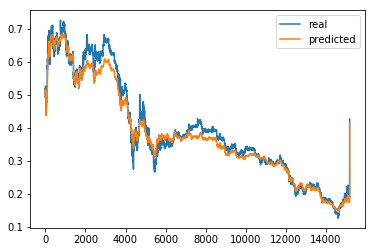

****** BCH ********
MAPE 3.3161808911726895


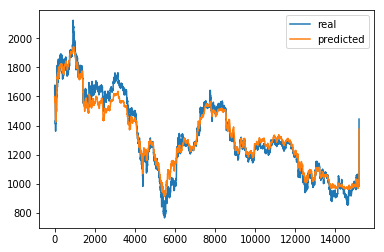

****** BTC ********
MAPE 2.138914141224523


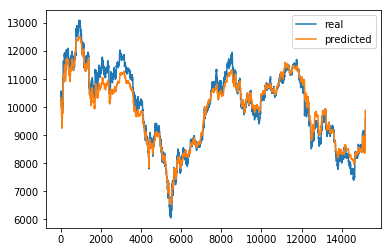

****** BTG ********
MAPE 4.58752072560097


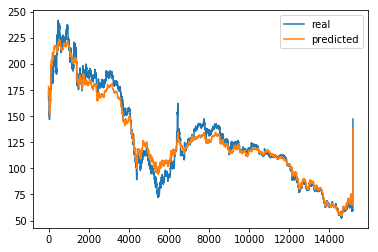

****** DASH ********
MAPE 3.13013061244038


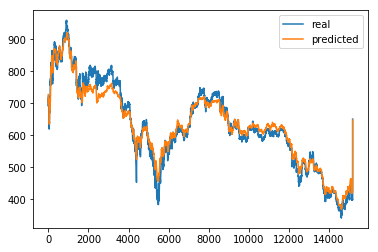

****** DOGE ********
MAPE 3.668149729772827


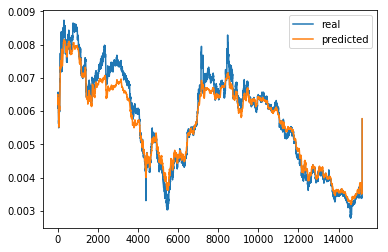

****** EOS ********
MAPE 3.3068094432843234


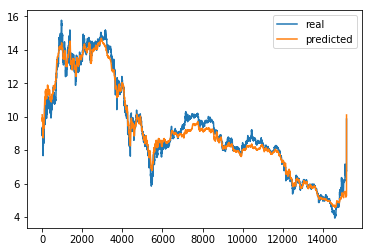

****** ETC ********
MAPE 3.953950374439847


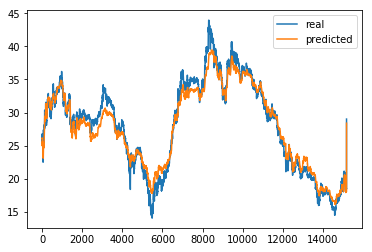

****** ETH ********
MAPE 3.438682468941031


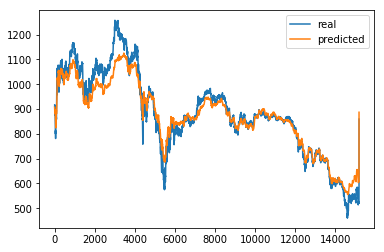

****** LSK ********
MAPE 4.3178600042858095


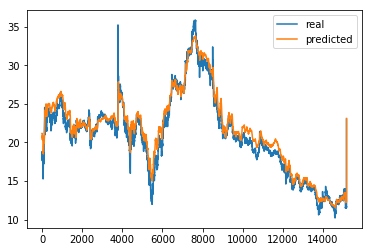

****** LTC ********
MAPE 2.5963341288123853


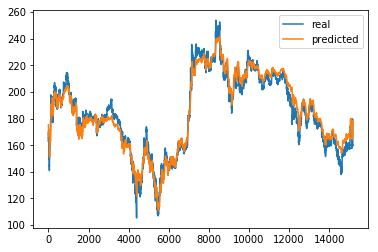

****** MIOTA ********
MAPE 4.48203034296238


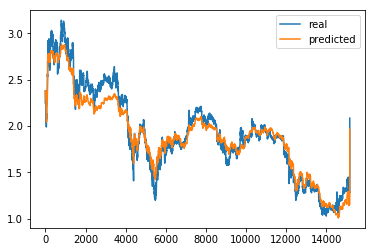

****** NEO ********
MAPE 4.9532291666424655


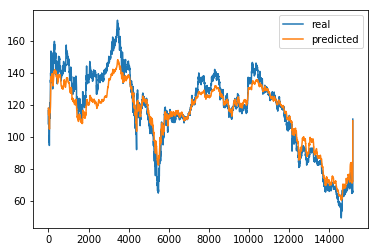

****** TRX ********
MAPE 3.788071832229204


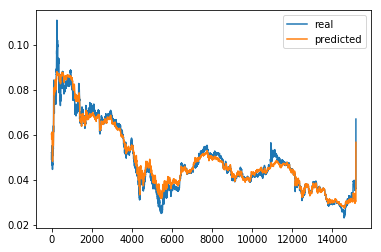

****** USDT ********
MAPE 0.3618854812556657


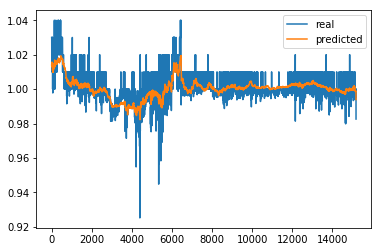

****** XEM ********
MAPE 5.541303759958429


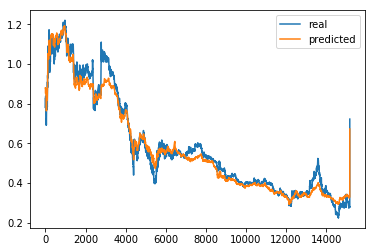

****** XLM ********
MAPE 3.2964737431484514


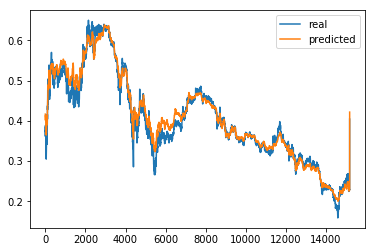

****** XMR ********
MAPE 2.7152352357172784


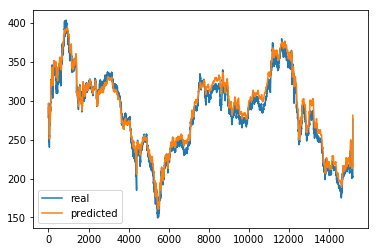

****** XRP ********
MAPE 3.3855495063996583


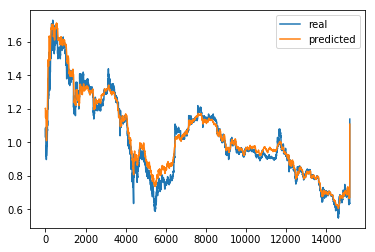

****** ZEC ********
MAPE 3.2495942571555094


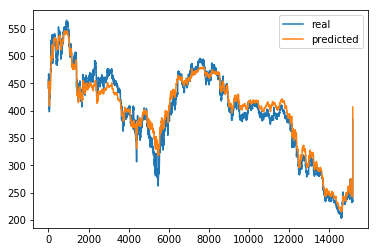

In [181]:
for coin in list(df.columns.values):
    real = Y[coin]
    predicted = results[coin]
    joint = pd.concat([real, predicted], keys=['real', 'predicted'],  axis=1, join='inner')
    print("******", coin , "********")
    print("MAPE", mape(joint.real ,joint.predicted))
    joint.plot()
    plt.show()